# Session 03 Homework

The goal of this homework is to create a classification model for determining if a bank client will subscribe a term deposit or not.

In [1]:
# Necessary import
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

## Get Data
We will use the `bank/bank-full.csv` file from the downloaded zip-file of the [Bank Marketing dataset](https://archive.ics.uci.edu/static/public/222/bank+marketing.zip).

In [2]:
# zip data url
bank_data = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"

In [5]:
# Get the zip-file
!wget $bank_data

In [7]:
# Unzip the `bank+marketing.zip` file
with zipfile.ZipFile('bank+marketing.zip', 'r') as bank_market:
    bank_market.extractall('') # extracting all files to current directory

We should first check the files available:

In [9]:
ls

 Le volume dans le lecteur C n’a pas de nom.
 Le numéro de série du volume est 2EFA-F61A

 Répertoire de C:\Users\dell\Videos\Elearning\Data Science\ML_Zoomcamp\ML_Zoomcamp_2024\03_classification\notebooks

15/10/2024  19:14    <DIR>          .
15/10/2024  19:14    <DIR>          ..
15/10/2024  11:27    <DIR>          .ipynb_checkpoints
15/10/2024  19:14           579 043 bank.zip
15/10/2024  11:53         1 023 843 bank+marketing.zip
15/10/2024  19:14           444 572 bank-additional.zip
13/10/2024  14:38           977 501 data-week-3.csv
14/10/2024  18:47             4 017 homework.md
15/10/2024  19:13            86 114 homework_session_03.ipynb
15/10/2024  16:15           232 163 logistic_regression.ipynb
               7 fichier(s)        3 347 253 octets
               3 Rép(s)  330 333 634 560 octets libres


Now, we can extract the dataset `bank-full.csv` from the `bank.zip` file:

In [11]:
# Extract only the `bank-full.csv` file
with zipfile.ZipFile('bank.zip', 'r') as bank:
    bank.extract('bank-full.csv', '') # extracting dataset to current directory

After extraction, let's read the data:

In [13]:
# Read the dataframe
df = pd.read_csv("bank-full.csv", sep = ";")

# Three last rows
df.tail(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,no


## Data Preparation

For the rest of the homework, we'll need only use these columns:
* `age`,
* `job`,
* `marital`,
* `education`,
* `balance`,
* `housing`,
* `contact`,
* `day`,
* `month`,
* `duration`,
* `campaign`,
* `pdays`,
* `previous`,
* `poutcome`,
* `y`
 
Let's subset our dataset:

In [15]:
# Select relevant features
subset = ["age", "job", "marital", "education", "balance", "housing", "contact", "day",
          "month", "duration", "campaign", "pdays", "previous", "poutcome", "y"]

# Create a subset of data
df_subset = df[subset]

Let's check if there are missing values:

In [17]:
# Check missing values
df_subset.isnull().sum()

age          0
job          0
marital      0
education    0
balance      0
housing      0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

### Question 1

The most frequent observation (mode) for the column `education` is *secondary*.

In [19]:
# `education` mode
df_subset.education.mode()

0    secondary
Name: education, dtype: object

### Question 2

After getting information about the data, we will create a correlation matrix for the numerical features:

In [22]:
# Dataset info
df_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


In [24]:
# Correlation matrix
df_subset_corr = df_subset.select_dtypes("number").corr()
df_subset_corr

,age,balance,day,duration,campaign,pdays,previous
age,1.000000,0.097783,-0.009120,-0.004648,0.004760,-0.023758,0.001288
balance,0.097783,1.000000,0.004503,0.021560,-0.014578,0.003435,0.016674
day,-0.009120,0.004503,1.000000,-0.030206,0.162490,-0.093044,-0.051710
duration,-0.004648,0.021560,-0.030206,1.000000,-0.084570,-0.001565,0.001203
campaign,0.004760,-0.014578,0.162490,-0.084570,1.000000,-0.088628,-0.032855
pdays,-0.023758,0.003435,-0.093044,-0.001565,-0.088628,1.000000,0.454820
previous,0.001288,0.016674,-0.051710,0.001203,-0.032855,0.454820,1.000000


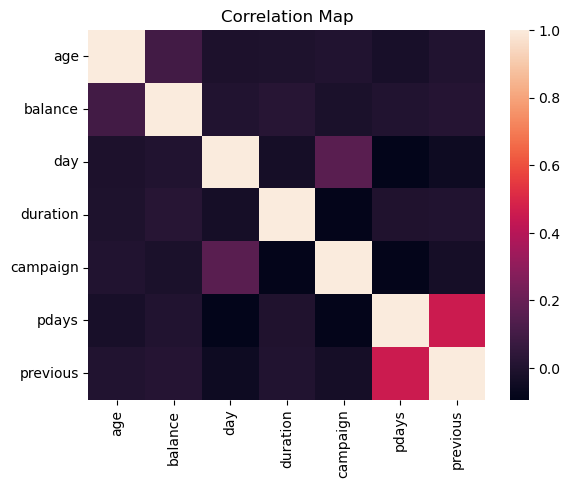

In [26]:
# Correlation map
plt.title("Correlation Map") # map title
sns.heatmap(df_subset_corr);

The two features with the biggest correlation are `pdays` and `previous`.

### Target encoding

Let's encode the `y` variable, replacing the values *yes*/*no* with *1*/*0*:

In [30]:
# Encoding `yes`/`no` to numerical values
df.y = (df.y == 1).astype(int)

### Split the data

 We will split the data into train/val/test sets with 60%/20%/20% distribution using Scikit-Learn (`train_test_split` function) with a seed of `42`:

In [32]:
# Splitting into full train and test
df_full_train, df_test = train_test_split(df_subset, test_size = 0.2, random_state = 42)

# Splitting into train and test
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [34]:
# Check datasets sizes after splitting
len(df_train), len(df_val), len(df_test)

(27126, 9042, 9043)

In [36]:
# Reset indexes
df_train = df_train.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)

Let's extract the target variable `y` from our dataframe:

In [38]:
# Get the target values
y_train = df_train.y.values
y_test = df_test.y.values
y_val = df_val.y.values

# Drop `y` from our data sets
del df_train["y"]
del df_test["y"]
del df_val["y"]

### Question 3

We calculate the mutual information scores (rounded to 2 decimals) between `y` and other categorical variables in the dataset, using only the training set. We will define a function to ease the process.

In [40]:
# Function to get mutual information sore with respect to the churn
def mutual_info_y_score(series):
    """
    This function takes a series and returns the mutual information score
    with respect to the `y` variable of the train set.
    """
    return mutual_info_score(series, y_train)

Now, we can apply this function to the categorical variables:

In [42]:
# Apply mutual information columnwise to categorical variables
mi_scores = df_train.select_dtypes("object").apply(mutual_info_y_score)

# Sourt scores in ascending order
mi_scores.sort_values(ascending = False)

poutcome     0.029533
month        0.025090
contact      0.013356
housing      0.010343
job          0.007316
education    0.002697
marital      0.002050
dtype: float64

The variable with the biggest mutual information score is `poutcome`.

### Question 4

 It's time to train a logistic regression model.
As we have several categorical variables in the dataset, we will first include them using one-hot encoding, and then, fit the model on the training dataset.

In [44]:
# Initialize vectorizer
One_Hot_encoder = DictVectorizer(sparse = False) # sparse when there are many categorical variables ---> most of them are 0s

# Convert training set to a dictionary
train_dict = df_train.to_dict(orient = 'records')

# Train the vectorizer and transform features
X_train = One_Hot_encoder.fit_transform(train_dict)

In [46]:
# Check the features
One_Hot_encoder.get_feature_names_out()

array(['age', 'balance', 'campaign', 'contact=cellular',
       'contact=telephone', 'contact=unknown', 'day', 'duration',
       'education=primary', 'education=secondary', 'education=tertiary',
       'education=unknown', 'housing=no', 'housing=yes', 'job=admin.',
       'job=blue-collar', 'job=entrepreneur', 'job=housemaid',
       'job=management', 'job=retired', 'job=self-employed',
       'job=services', 'job=student', 'job=technician', 'job=unemployed',
       'job=unknown', 'marital=divorced', 'marital=married',
       'marital=single', 'month=apr', 'month=aug', 'month=dec',
       'month=feb', 'month=jan', 'month=jul', 'month=jun', 'month=mar',
       'month=may', 'month=nov', 'month=oct', 'month=sep', 'pdays',
       'poutcome=failure', 'poutcome=other', 'poutcome=success',
       'poutcome=unknown', 'previous'], dtype=object)

In [48]:
# Define the model
model = LogisticRegression(solver = 'liblinear', C = 1.0, max_iter = 1000, random_state = 42)

# Model fitting
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')

We prepare the validation dataset and calculate the model accuracy using it:

In [50]:
# Convert validation set to a dictionary
val_dict = df_val.to_dict(orient = 'records')

# Transform validation data
X_val = One_Hot_encoder.transform(val_dict)

In [52]:
# Make predictions
y_pred = model.predict(X_val)

# Accuracy score
accuracy = (y_pred == y_val).mean()
round(accuracy, 2)

0.9

The accuracy obtained is $90 \%$.

We can define a function to train models quickly, and speed fine-tuning and feature elimination for the following questions.

In [55]:
# Function to train a regression model
def log_reg_train(elim = False, feature = "None", C = 1):
    """
    Function to train a logistic regression model specifying a regularization parameter,
    and potentially removing one feature from the dataset.
    ---
    elim: bool value to indicate if a feature shld be removed from the training set,
            False by default
    feature: feature to remove from the training dataset.
            None by default
    C: regularization parameter
            1 by default.
    """
    # Initialize vectorizer
    One_Hot_encoder = DictVectorizer(sparse = False)

    # Drop feature if required
    if elim:
        train = df_train.drop(columns = feature)
        val = df_val.drop(columns = feature)
    else:
        train = df_train
        val = df_val
        
    # Convert training set to a dictionary
    train_dict = train.to_dict(orient = 'records')
    
    # Train the vectorizer and transform features
    X_train = One_Hot_encoder.fit_transform(train_dict)
    
    # Define the model
    model = LogisticRegression(solver = 'liblinear', C = C,
                               max_iter = 1000, random_state = 42)
    
    # Model fitting
    model.fit(X_train, y_train)
    
    # Convert validation set to a dictionary
    val_dict = val.to_dict(orient = 'records')
    
    # Transform validation data
    X_val = One_Hot_encoder.transform(val_dict)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Accuracy score
    accuracy = (y_pred == y_val).mean()

    # return accuracy
    return accuracy

### Question 5 

Let's find the least useful feature using the *feature elimination* technique.
For this purpose, we should train a model with all these features (done in `Question 4`), exclude one feature from this set and train a model without it, recording its accuracy and the absolute difference with the original accuracy (in `Question 4`) and repeating this process for all the features.

In [57]:
# Feature names
features = df_train.columns.to_list()

# Initialize scores and differences
scores = []
differences = []

# Feature elimination
for feat in features:
    # Accuracy without `feat` as feature
    no_feat_score = log_reg_train(elim = True, feature = feat, C = 1)

    # Append score
    scores += [no_feat_score]

    # Append difference
    differences += [abs(accuracy - no_feat_score)]

# Series for scores and differences
scores = pd.Series(scores, index = features, name = "scores")
differences = pd.Series(differences, index = features, name = "abs_differences")

# Dataframe with results
feat_elim_result = pd.concat([scores, differences], axis = 1)
feat_elim_result

,scores,abs_differences
age,0.900243,0.001327
job,0.901128,0.000442
marital,0.901239,0.000332
education,0.901017,0.000553
balance,0.900686,0.000885
housing,0.901017,0.000553
contact,0.900354,0.001217
day,0.900133,0.001438
month,0.899912,0.001659
duration,0.890179,0.011391


The feature with the smallest difference among `age`, `balance`, `marital`, and `previous` is `previous`.

### Question 6

We will now fine tune our logistic regression model on all the features by searching the best regularization parameter `C` among the list: `[0.01, 0.1, 1, 10, 100]`. The accuracy will be calculated on the validation dataset and rounded to 3 decimal digits.

In [59]:
# Parameter list
reg_params = [0.01, 0.1, 1, 10, 100]

# Initialize scores
reg_params_scores = []

# Parameter Fine-Tuning
for param in reg_params:
    # Compute accuracy
    param_score = log_reg_train(C = param)

    # Append rounded score
    reg_params_scores += [round(no_feat_score, 3)]

# Series for parameters scores
param_scores = pd.Series(reg_params_scores, index = reg_params, name = "parameters_scores")
param_scores

0.01      0.894
0.10      0.894
1.00      0.894
10.00     0.894
100.00    0.894
Name: parameters_scores, dtype: float64

The smallest `C` leading to the best accuracy on the validation set is `0.01`.

---